## Example of binary classification with a MLP

This example use the Ionosphere binary (two class) classification dataset to demonstrate an MLP for binary classification.

This dataset involves predicting whether there is a structure in the atmosphere or not given radar returns.

Details about the dataset can be found on:

- [Ionosphere Dataset (csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv)
- [Ionosphere Dataset Description](https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.names)

Each data instance has 34 features (float values between -1.0 and 1.0) plus the class feature (`g` for good and `b` for bad).

`LabelEncoder` from scikit-learn is used to encode the string labels to integer values 0 and 1.

In [1]:
from numpy import vstack
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch import Tensor
 
class CSVDataset(Dataset):
    def __init__(self):
        # load the csv file as a dataframe
        df = read_csv(
            'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv', 
            header=None)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
        self.y = self.y.astype('float32')
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])
 

In [7]:
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 16)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer and output
        self.hidden2 = Linear(16, 1)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = Sigmoid()

    def forward(self, x):
        # input to first hidden layer
        X = self.hidden1(x)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        return X


In [10]:
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.nn import BCELoss

dataset = CSVDataset()
train, test = dataset.get_splits()
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=1024, shuffle=False)

model = MLP(len(dataset[0][0]))
criterion = BCELoss()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = []
# enumerate epochs
for epoch in range(100):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_dl):
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss)


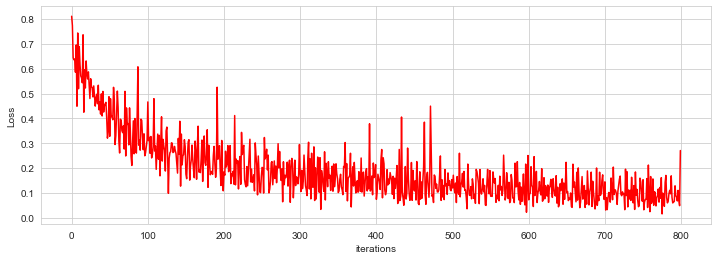

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style(style = 'whitegrid')
plt.rcParams["patch.force_edgecolor"] = True

plt.figure(figsize = (12,4))
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

In [9]:
from sklearn.metrics import accuracy_score

predictions, actuals = list(), list()
for i, (inputs, targets) in enumerate(test_dl):
    # evaluate the model on the test set
    yhat = model(inputs)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    actual = targets.numpy()
    actual = actual.reshape((len(actual), 1))
    # round to class values
    yhat = yhat.round()
    # store
    predictions.append(yhat)
    actuals.append(actual)

predictions, actuals = vstack(predictions), vstack(actuals)
# calculate accuracy
acc = accuracy_score(actuals, predictions)
print('Accuracy: %.3f' % acc)

Accuracy: 0.897


Sources:
- https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/